# Comparing a-Priori SBM Fitting with Different Groupings #

It is often desirable to create models of data so we can generate new samples, learn something about the data's structure,
or for use in some larger analysis. SBM models define different connection probabilities for different communities in
a graph.

Here we enforce a community structure a-priori based a some connectome attributes or combinations thereof, and fit an SBM.
In this case, the connection probability between two blocks is simply the total number of observed connections between them,
divided by the total number of possible connections between them.

We fit these SBMs using different attributes or combinations of attributes from the connectome, and then compute the
BIC (Bayesian Information Criterion) for each model. This gives us an idea of which attributes best explain the topological
structure of the connectome.

For consistency, we use the attributes `hemisphere` (the side of the brain a neuron is on), `cell_type` (the high-level
classification of a neuron as interneuron, sensory, or motor) and their combination as groups for fitting. The analysis
is only preformed on the Ciona Intestinalis Connectome, two C. Elegans Worm Wiring Connectomes, and the 8 C. Elegans
Developmental Connectomes, because only these have both those attributes defined.

*Note that the code to do the actual SBM fitting is located in `analysis/apriori_sbm_code.py`*

In [1]:
import os
import sys
import matplotlib.pyplot as plt
sys.path.append("../")
import pandas as pd
from graph import GraphIO
from analysis.apriori_sbm_code import fit_apriori_sbm
import seaborn as sns
import numpy as np

## Ciona Intestinalis ##
We'll start with the single Ciona Connectome. First we load the data:

In [2]:
path = '../json_connectomes/ciona.json'
ciona_connectome, _, _, _ = GraphIO.load(path)

Now we'll fit an SBM for each grouping

In [3]:
# In Ciona, Hemisphere is called side and cell_type is called annotation
groups = [['Side'], ['Annotation'], ['Side', 'Annotation']]
rows = {'Ciona Intestinalis': {}}
for group in groups:
    rows['Ciona Intestinalis'][str(group)] = fit_apriori_sbm(ciona_connectome, group, plot_sbms=False)
ciona_results = pd.DataFrame.from_dict({(i,j): rows[i][j]
                           for i in rows.keys()
                           for j in rows[i].keys()},
                       orient='index')
ciona_results.head()

bic    likelihood  \
Ciona Intestinalis ['Side']               -23033.922165 -10863.237119   
                   ['Annotation']         -22820.202349 -11323.658336   
                   ['Side', 'Annotation'] -26206.331665 -10245.149497   

                                           n_params       estimator  
Ciona Intestinalis ['Side']                     121  SBMEstimator()  
                   ['Annotation']                16  SBMEstimator()  
                   ['Side', 'Annotation']       529  SBMEstimator()

Great, now lets plot -BIC for different groupings. The lowest -BIC is set to 0, since the scale doesn't really matter here.

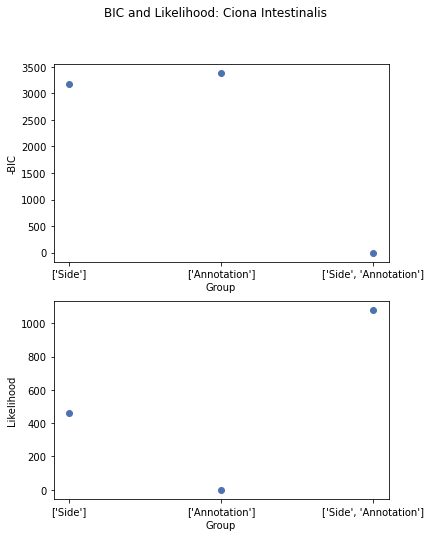

In [4]:
colors = sns.color_palette("deep")[0]
fig, ax = plt.subplots(2, 1)
out_index = ciona_results.index.levels[0]
for i, key in enumerate(out_index):
    data = ciona_results.loc[key]
    bic_data = data['bic'].to_numpy()
    norm_bic = bic_data - np.min(bic_data)
    like_data = data['likelihood'].to_numpy()
    norm_like = like_data - np.min(like_data)
    _ = ax[0].scatter(data['bic'].index,
                  norm_bic,
                  label=key,
                  color=np.array(colors))
    _ = ax[1].scatter(data['likelihood'].index,
                  norm_like,
                  label=key,
                  color=np.array(colors))
    _ = ax[0].set(xlabel='Group', ylabel='-BIC')
    _ = ax[1].set(xlabel='Group', ylabel='Likelihood')
_ = fig.suptitle('BIC and Likelihood: Ciona Intestinalis')
_ = fig.set_size_inches(6, 8)

It appears annotation has the best BIC but the worst likelihood. This could be because annotation has much fewer parameters than the other groupings. (For Ciona
'Side' is broken into 11 groupings instead of just 'Left' and 'Right'). Therefore, based on
the BIC, annotation explains the structure better, and the other groupings are likely
fitting noise.

## C. Elegans Developmental Conectomes (Witviliet) ##

We will preform this analysis for all 8 developmental stages at once.

In [5]:
# load some elegans Witvliet data
base = '../json_connectomes/witvilet/'
graph_files = sorted(os.listdir(base))
wit_connectomes = []
for f in graph_files:
    # These contain multiple synapse types, and thus can have multiedges and need to be flattened.
    # Alternatively, we could preform the analysis separately for each synapse type
    wit_connectomes.append(GraphIO.flatten_multigraph(GraphIO.load(os.path.join(base, f))[0]))

Now we will fit sbms for each grouping for each connectome.

In [6]:
groups = [["hemisphere"], ["cell_type0"], ["hemisphere", "cell_type0"]]
rows = {}
ages = []
for i in range(len(wit_connectomes)):
    age = wit_connectomes[i].graph['age']
    ages.append(age)
    g_row = {}
    for group in groups:
        g_row[str(group)] = fit_apriori_sbm(wit_connectomes[i], group, plot_sbms=False)
    rows['Witvliet ' + str(age) + ' hours'] = g_row
wit_results = pd.DataFrame.from_dict({(i,j): rows[i][j]
                           for i in rows.keys()
                           for j in rows[i].keys()},
                       orient='index')
ages = np.array(ages)
wit_results.head(24)


bic   likelihood  \
Witvliet 0 hours  ['hemisphere']                -8016.577339 -3961.208692   
                  ['cell_type0']                -7651.218552 -3694.831560   
                  ['hemisphere', 'cell_type0']  -8917.613900 -3574.749594   
Witvliet 5 hours  ['hemisphere']                -9913.659242 -4909.418897   
                  ['cell_type0']                -9401.135504 -4510.924858   
                  ['hemisphere', 'cell_type0'] -10818.117288 -4376.558445   
Witvliet 8 hours  ['hemisphere']               -10035.203502 -4970.007348   
                  ['cell_type0']                -9387.116384 -4561.351516   
                  ['hemisphere', 'cell_type0'] -10628.877074 -4420.721409   
Witvliet 16 hours ['hemisphere']               -11716.860426 -5810.567133   
                  ['cell_type0']               -10907.811713 -5320.952857   
                  ['hemisphere', 'cell_type0'] -12142.430570 -5172.453006   
Witvliet 23 hours ['hemisphere']               -14771.539210 -7337.602882   
                  ['cell_type0']               -13806.911934 -6710.789074   
                  ['hemisphere', 'cell_type0'] -15164.255483 -6533.163547   
Witvliet 27 hours ['hemisphere']               -14586.909618 -7245.077303   
                  ['cell_type0']               -13437.319264 -6584.277672   
                  ['hemisphere', 'cell_type0'] -14596.318736 -6389.737317   
Witvliet 45 hours ['hemisphere']               -19049.862125 -9476.429417   
                  ['cell_type0']               -17546.406610 -8579.196723   
                  ['hemisphere', 'cell_type0'] -19108.022424 -8341.470073   

                                                n_params       estimator  
Witvliet 0 hours  ['hemisphere']                       9  SBMEstimator()  
                  ['cell_type0']                      25  SBMEstimator()  
                  ['hemisphere', 'cell_type0']       169  SBMEstimator()  
Witvliet 5 hours  ['hemisphere']                       9  SBMEstimator()  
                  ['cell_type0']                      36  SBMEstimator()  
                  ['hemisphere', 'cell_type0']       196  SBMEstimator()  
Witvliet 8 hours  ['hemisphere']                       9  SBMEstimator()  
                  ['cell_type0']                      25  SBMEstimator()  
                  ['hemisphere', 'cell_type0']       169  SBMEstimator()  
Witvliet 16 hours ['hemisphere']                       9  SBMEstimator()  
                  ['cell_type0']                      25  SBMEstimator()  
                  ['hemisphere', 'cell_type0']       169  SBMEstimator()  
Witvliet 23 hours ['hemisphere']                       9  SBMEstimator()  
                  ['cell_type0']                      36  SBMEstimator()  
                  ['hemisphere', 'cell_type0']       196  SBMEstimator()  
Witvliet 27 hours ['hemisphere']                       9  SBMEstimator()  
                  ['cell_type0']                      25  SBMEstimator()  
                  ['hemisphere', 'cell_type0']       169  SBMEstimator()  
Witvliet 45 hours ['hemisphere']                       9  SBMEstimator()  
                  ['cell_type0']                      36  SBMEstimator()  
                  ['hemisphere', 'cell_type0']       225  SBMEstimator()

Let's plot -BIC for different groupings. Again the lowest -BIC for each developmental stage is set to 0, allowing for easy comparison.

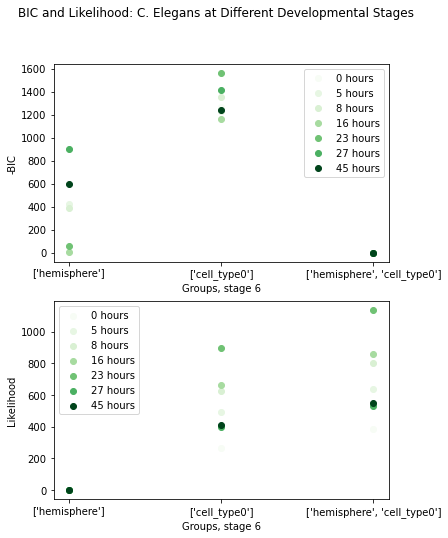

In [7]:
fig, ax = plt.subplots(2)
out_index = wit_results.index.levels[0]
cm = plt.cm.get_cmap('Greens')
colors = cm(ages/max(ages))
for i, key in enumerate(out_index):
    data = wit_results.loc[key]
    bic_data = data['bic'].to_numpy()
    norm_bic = bic_data - np.min(bic_data)
    like_data = data['likelihood'].to_numpy()
    norm_like = like_data - np.min(like_data)
    _ = ax[0].scatter(data['bic'].index,
                     norm_bic,
                     label=str(ages[i]) + ' hours',
                     color=np.array(colors)[i])
    _ = ax[1].scatter(data['likelihood'].index,
                     norm_like,
                     label=str(ages[i]) + ' hours',
                     color=np.array(colors)[i])
    _ = ax[0].set(xlabel='Groups, stage ' + str(i), ylabel='-BIC')
    _ = ax[1].set(xlabel='Groups, stage ' + str(i), ylabel='Likelihood')
_ = fig.suptitle('BIC and Likelihood: C. Elegans at Different Developmental Stages')
_ = fig.set_size_inches(6, 8)
_ = ax[0].legend(loc='best')
_ = ax[1].legend(loc='best')

Once again, we find that cell type explains the topology the best. This is still not entirely surprising, since the
connectivity of interneurons should be very different than that of sensory or motor neurons

## C. Elegans Male and Hermaphrodite Conectomes (Worm Wiring) ##

In [8]:
# load chemical synapse connectome files
path_h = '../json_connectomes/worm_wiring/connectome/Hermaphrodite/0.json'
path_m = '../json_connectomes/worm_wiring/connectome/Male/0.json'
ww_connectomes = []
ww_connectomes.append(GraphIO.load(path_h)[0])
ww_connectomes.append(GraphIO.load(path_m)[0])

In [9]:
groups = [["hemisphere"], ["cell_type0"], ["hemisphere", "cell_type0"]]
types = ['Hermaphrodite', 'Male']
rows = {}
for i in range(len(ww_connectomes)):
    g_row = {}
    for group in groups:
        g_row[str(group)] = fit_apriori_sbm(ww_connectomes[i], group, plot_sbms=False)
    rows['C. Elegans ' + types[i]] = g_row
ww_results = pd.DataFrame.from_dict({(i,j): rows[i][j]
                           for i in rows.keys()
                           for j in rows[i].keys()},
                       orient='index')
ww_results.head(6)

bic  \
C. Elegans Hermaphrodite ['hemisphere']               -45484.654884   
                         ['cell_type0']               -37783.419558   
                         ['hemisphere', 'cell_type0'] -41098.822390   
C. Elegans Male          ['hemisphere']               -53425.404138   
                         ['cell_type0']               -43612.375238   
                         ['hemisphere', 'cell_type0'] -47806.496439   

                                                         likelihood  n_params  \
C. Elegans Hermaphrodite ['hemisphere']               -22687.264567         9   
                         ['cell_type0']               -18500.151558        64   
                         ['hemisphere', 'cell_type0'] -17588.252151       484   
C. Elegans Male          ['hemisphere']               -26655.512739         9   
                         ['cell_type0']               -21399.507936        64   
                         ['hemisphere', 'cell_type0'] -20541.786468       529   

                                                            estimator  
C. Elegans Hermaphrodite ['hemisphere']                SBMEstimator()  
                         ['cell_type0']                SBMEstimator()  
                         ['hemisphere', 'cell_type0']  SBMEstimator()  
C. Elegans Male          ['hemisphere']                SBMEstimator()  
                         ['cell_type0']                SBMEstimator()  
                         ['hemisphere', 'cell_type0']  SBMEstimator()

One last time, we'll plot -BIC and Likelihood, the lowest -BIC is again set to 0.

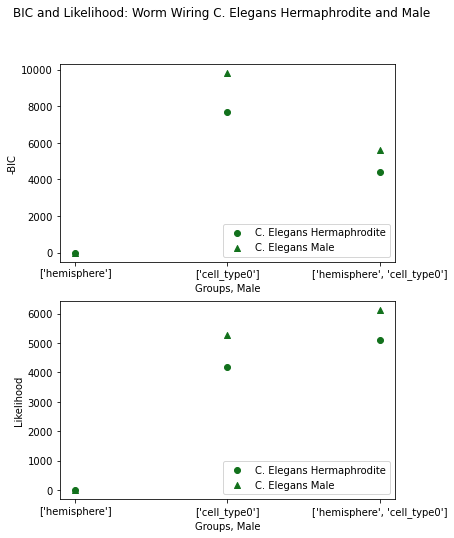

In [10]:
fig, ax = plt.subplots(2)
out_index = ww_results.index.levels[0]
colors = sns.color_palette("dark")[2]
for i, key in enumerate(out_index):
    data = ww_results.loc[key]
    bic_data = data['bic'].to_numpy()
    norm_bic = bic_data - np.min(bic_data)
    like_data = data['likelihood'].to_numpy()
    norm_like = like_data - np.min(like_data)
    if 'Male' in key:
        shape = '^'
    else:
        shape = 'o'
    _ = ax[0].scatter(data['bic'].index,
                     norm_bic,
                     label=key,
                     color=np.array(colors),
                     marker=shape,)
    _ = ax[1].scatter(data['likelihood'].index,
                     norm_like,
                     label=key,
                     color=np.array(colors),
                     marker=shape,)
    _ = ax[0].set(xlabel='Groups, ' + types[i], ylabel='-BIC')
    _ = ax[1].set(xlabel='Groups, ' + types[i], ylabel='Likelihood')
_ = ax[0].legend(loc='best')
_ = ax[1].legend(loc='best')
_ = fig.suptitle('BIC and Likelihood: Worm Wiring C. Elegans Hermaphrodite and Male')
_ = fig.set_size_inches(6, 8)

For a third time, cell type groupings get the best BIC. This makes sense since this is the same species as the developmental data
